4.83 s for network with 6174 neurons, run for 0.5 s


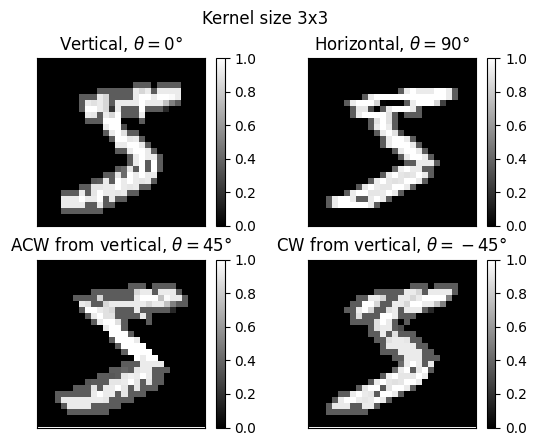

In [4]:
from brian2 import *
%matplotlib inline
import numpy as np
import pytime
import mnist

x_train, t_train, x_test, t_test = mnist.load()

ind = 0
pat = x_train[ind,:]
# plt.imshow(img.reshape(28,28),cmap='gray')
# plt.title(t_train[ind])
# plt.show()

def visualize_Hypercolumn(mfrV1, real_digit, n, FR, k_size):

    titles = [r'Vertical, $\theta=0°$', r'Horizontal, $\theta=90°$', r'ACW from vertical, $\theta=45°$', r'CW from vertical, $\theta=-45°$']
    nL = n**2
    mfr = np.zeros((n,n,4))
    mfr_mean = np.zeros((n,n))
    
    for ii in range(4):
        
        tmp = mfrV1[nL*ii : nL*(ii+1)]/FR
        tmp = tmp.reshape(n,n)
        mfr[:,:,ii] = asarray(tmp)
        mfr_mean += tmp/4
        
        
        plt.subplot(2,2,ii+1)
        plt.imshow(tmp,cmap='gray',vmin=0,vmax=1)
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[ii])
        plt.suptitle(f'Kernel size {k_size}x{k_size}')
        '''
    
    plt.figure()
    plt.imshow(mfr_mean,cmap='gray',vmin=0,vmax=1)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Real digit: {real_digit}')
    '''
    
n = 28
nL1 = nL2 = n**2
nL3 = nL1*4

[X,Y] = np.meshgrid(range(n), range(n))

taum = 10*ms
taue = taui = 5*ms
duration = 500*ms

eqsPOISSON ='''
rates : Hz
x : 1 (constant)
y : 1 (constant)
'''

eqsLGN ='''
dv/dt  = (ge-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
x : 1 (constant)
y : 1 (constant)
'''

eqsV1 ='''
dv/dt  = (ge-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
x : 1 (constant)
y : 1 (constant)
ori : 1 (constant)
'''

################################################## Layer 1 ################################################################

L1 = NeuronGroup(nL1,
                 eqsPOISSON,
                 threshold='rand()<rates*dt')

L1.x = X.flatten()
L1.y = Y.flatten()
FR = 100*Hz
L1.rates = pat*FR

################################################## Layer 2 ################################################################

L2 = NeuronGroup(nL2,
                 eqsLGN,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L2.x = X.flatten()
L2.y = Y.flatten()

e1 = Synapses(L1, L2, on_pre='ge += 8*volt')
e1.connect(condition = 'i==j')

i1 = Synapses(L1, L2, on_pre='ge -= 1*volt')
i1.connect(condition = 'sqrt((x_pre - x_post)**2 + (y_pre-y_post)**2) < 2 and i!=j')

################################################## Layer 3 ################################################################

L3 = NeuronGroup(nL3,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L3.ori = np.repeat(np.array([0,1,2,3]), nL1)

X3 = np.tile(X.flatten(), (1,4))
X3.flatten()
L3.x = X3.flatten()

Y3 = np.tile(Y.flatten(), (1,4))
Y3.flatten()
L3.y = Y3.flatten()

e2 = Synapses(L2, L3, on_pre='ge += 1/3*volt')
cond_ver = 'ori_post==0 and (y_pre-y_post)**2<=1 and x_pre==x_post or '
cond_hor = 'ori_post==1 and (x_pre-x_post)**2<=1 and y_pre==y_post or '
cond_TLBR = 'ori_post==2 and (x_pre==x_post-1 and y_pre==y_post-1 or x_pre==x_post and y_pre==y_post or x_pre==x_post+1 and y_pre==y_post+1) or '
cond_TRBL = 'ori_post==3 and (x_pre==x_post+1 and y_pre==y_post-1 or x_pre==x_post and y_pre==y_post or x_pre==x_post-1 and y_pre==y_post+1)'
condV1 = cond_ver + cond_hor + cond_TLBR + cond_TRBL
e2.connect(condition = condV1)

############################################# Layer 1 Scale 2 #############################################################

nS2 = int(n/2)
nL1S2 = nL2S2 = nS2**2
nL3S2 = nL2S2*4

[XS2,YS2] = np.meshgrid(range(nS2), range(nS2))

L1S2 = NeuronGroup(nL1S2,
                 eqsLGN,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L1S2.x = XS2.flatten()
L1S2.y = YS2.flatten()

e1s2 = Synapses(L1, L1S2, on_pre='ge += 1/4*volt')
e1s2.connect(condition = '(x_post==x_pre/2 or x_post==(x_pre-1)/2) and (y_post==y_pre/2 or y_post==(y_pre-1)/2)')

############################################# Layer 2 Scale 2 #############################################################

L2S2 = NeuronGroup(nL2S2,
                 eqsLGN,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L2S2.x = XS2.flatten()
L2S2.y = YS2.flatten()

e2s2 = Synapses(L1S2, L2S2, on_pre='ge += 8*volt')
e2s2.connect(condition = 'i==j')

i2s2 = Synapses(L1S2, L2S2, on_pre='ge -= 1*volt')
i2s2.connect(condition = 'sqrt((x_pre - x_post)**2 + (y_pre-y_post)**2) < 2 and i!=j')

############################################# Layer 3 Scale 2 #############################################################

L3S2 = NeuronGroup(nL3S2,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L3S2.ori = np.repeat(np.array([0,1,2,3]), nL1S2)

X3S2 = np.tile(XS2.flatten(), (1,4))
X3S2.flatten()
L3S2.x = X3S2.flatten()

Y3S2 = np.tile(YS2.flatten(), (1,4))
Y3S2.flatten()
L3S2.y = Y3S2.flatten()

e3s2 = Synapses(L2S2, L3S2, on_pre='ge += 1/3*volt')
e3s2.connect(condition = condV1)

############################################# Layer 1 Scale 3 #############################################################

nS3 = int(nS2/2)
nL1S3 = nL2S3 = nS3**2
nL3S3 = nL2S3*4

[XS3,YS3] = np.meshgrid(range(nS3), range(nS3))

L1S3 = NeuronGroup(nL1S3,
                 eqsLGN,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L1S3.x = XS3.flatten()
L1S3.y = YS3.flatten()

e1s3 = Synapses(L1S2, L1S3, on_pre='ge += 1/4*volt')
e1s3.connect(condition = '(x_post==x_pre/2 or x_post==(x_pre-1)/2) and (y_post==y_pre/2 or y_post==(y_pre-1)/2)')

############################################# Layer 2 Scale 3 #############################################################

L2S3 = NeuronGroup(nL2S3,
                 eqsLGN,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L2S3.x = XS3.flatten()
L2S3.y = YS3.flatten()

e2s3 = Synapses(L1S3, L2S3, on_pre='ge += 8*volt')
e2s3.connect(condition = 'i==j')

i2s3 = Synapses(L1S3, L2S3, on_pre='ge -= 1*volt')
i2s3.connect(condition = 'sqrt((x_pre - x_post)**2 + (y_pre-y_post)**2) < 2 and i!=j')

############################################# Layer 3 Scale 3 #############################################################

L3S3 = NeuronGroup(nL3S3,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L3S3.ori = np.repeat(np.array([0,1,2,3]), nL1S3)

X3S3 = np.tile(XS3.flatten(), (1,4))
X3S3.flatten()
L3S3.x = X3S3.flatten()

Y3S3 = np.tile(YS3.flatten(), (1,4))
Y3S3.flatten()
L3S3.y = Y3S3.flatten()

e3s3 = Synapses(L2S3, L3S3, on_pre='ge += 1/3*volt')
e3s3.connect(condition = condV1)

###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


nTot = nL1+nL2+nL3 +nL1S2+nL2S2+nL3S2 +nL1S3+nL2S3+nL3S3

sp1 = SpikeMonitor(L3)
sp2 = SpikeMonitor(L3S2)
sp3 = SpikeMonitor(L3S3)

start = time.time()
run(duration)
print(f'{time.time()-start:.2f} s for network with {nTot} neurons, run for {duration}')

MFR1 = sp1.count/duration
MFR2 = sp2.count/duration
MFR3 = sp3.count/duration

visualize_Hypercolumn(MFR1, t_train[ind], n, FR, 3)

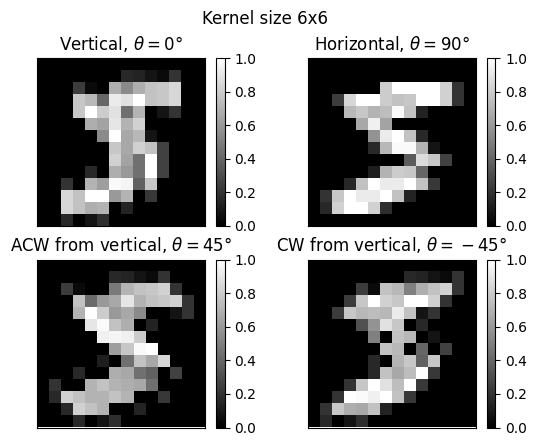

In [5]:
visualize_Hypercolumn(MFR2, t_train[ind], nS2, FR, 6)

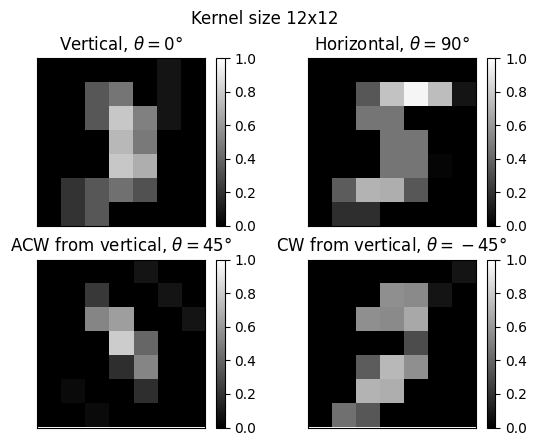

In [6]:
visualize_Hypercolumn(MFR3, t_train[ind], nS3, FR, 12)